# Импорт библиотек

In [2]:
import json

import bz2
import re
import ast
from tqdm import tqdm
from scipy import sparse

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/viktorianadsonova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
import pandas as pd
import numpy as np
import pymorphy3
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


#  Домашнее задание по NLP # 2 [100 баллов]
## Составление словарей для классификации по тональности
При классификации текстов или предложений по тональности необходимо использовать оценочные словари для предметной области, то есть, такие словари, в которых содержатся отрицательные и позитивные слова для какой-то предметной области. Идея подобных словарей основана на следующих наблюдениях: во-первых, для разных товаров используются разные оценочные слова (например бывает “захватывающая книга”, но не бывает “захватывающих лыж”), во-вторых, в контексте разных товаров одни и те же слова могут иметь разную окраску (слово “тормоз” в отзыве на велосипед имеет нейтральную окраску, в отзыве на компьютер – резко негативную, “пыль” в контексте пылесосов – нейтральную, в контексте кофемолок – положительную (“мелкий помол в пыль”)). Еще один пример: "теплое пиво" – это плохо, а "теплый свитер" – это хорошо.  

Составление таких словарей в ручную – трудоемкий процесс, но, к счастью, его не сложно автоматизировать, если собрать достаточно большие корпуса отзывов. В этом домашнем задании вам предстоит попробовать реализовать один их подходов к составлению оценочных словарей, основанный на статье Inducing Domain-Specific Sentiment Lexicons from Unlabeled Corpora (https://nlp.stanford.edu/pubs/hamilton2016inducing.pdf).


Данные для задания – уже знакомые вам отзывы на банки, собранные с нескольких сайтов Рунета. Отзывы могут быть как положительными (оценка 5), так и отрицательными (оценка 1).

In [4]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [00:22, 8785.61it/s] 


In [5]:
df = pd.DataFrame.from_dict(responses)
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


## Часть 1. Обучение модели word2vec [50 баллов]

1. Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова.
2. Обучите по коллекции предложений word2vec
3. Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:
    * тест на определение ближайших слов
    * тест на аналогии (мужчина – король : женщина – королева)
    * тест на определение лишнего слова.
    
4. Постройте несколько визуализаций:
    * TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов
    * задайте координаты для нового пространства следующим образом: одна  ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах.  Более формально:
    берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.  



Ссылка на примеры визуализаций: https://towardsdatascience.com/game-of-thrones-word-embeddings-does-r-l-j-part-2-30290b1c0b4b

### Обучение модели

In [6]:
df['text_clear'] = df.text.str.lower()

df['text_clear'] = df['text_clear'].str.replace(r'юр\.( )*лиц', 'юр лиц', regex=True)
df['text_clear'] = df['text_clear'].str.replace(r'физ\.( )*лиц', 'физ лиц', regex=True)
df['text_clear'] = df['text_clear'].str.replace(' руб.', ' руб')
df['text_clear'] = df['text_clear'].str.replace(' млн.', ' млн')
df['text_clear'] = df['text_clear'].str.replace(' тыс.', ' тыс')

df['text_clear'] = df['text_clear'].str.replace(' т.ч.', '')
df['text_clear'] = df['text_clear'].str.replace(' т.к.', '')
df['text_clear'] = df['text_clear'].str.replace(' т.о.', '')
df['text_clear'] = df['text_clear'].str.replace(' т.е.', '')
df['text_clear'] = df['text_clear'].str.replace(' г.', '')
df['text_clear'] = df['text_clear'].str.replace('\xa0', '')

df['text_clear'] = df['text_clear'].str.replace(r'!+|\?+', '.', regex=True)
df['text_clear'] = df['text_clear'].str.replace(r'\d{2,4}[\.|\-]\d{2,4}[\.|\-]\d{2,4}', '', regex=True)
df['text_clear'] = df['text_clear'].str.replace(r'[^а-я\.]', ' ', regex=True)
df['text_clear'] = df['text_clear'].str.replace(r'\s+', ' ', regex=True)
df['text_clear'] = df['text_clear'].str.replace(r'\.+\s*', '.', regex=True)

In [7]:
df['sentences'] = df['text_clear'].str.split('.')

In [8]:
def get_lemmatized_text(text):

  lemm_text = []
  for word in text.split():
    norm_text = analyzer.parse(word)[0].normal_form
    if (norm_text not in ru_stopwords) and (len(norm_text) > 2):
      lemm_text.append(norm_text)

  return lemm_text # ' '.join(lemm_text) if len(lemm_text) > 1 else ''

def get_lemmatized_sentences(sentences):

  lemm_sentences = []
  for text in sentences:
    lemm_text = get_lemmatized_text(text)
    if lemm_text != '':
      lemm_sentences.append(lemm_text)

  return lemm_sentences

In [10]:
# analyzer = pymorphy3.MorphAnalyzer()
# ru_stopwords = stopwords.words("russian")

# df['lemm_sentences'] = df['sentences'].apply(get_lemmatized_sentences)
# df['lemm_sentences'].to_csv('lemm_texts.csv')

In [5]:
df_lemm = pd.read_csv('./lemm_texts.csv')

lemm_data = []
for text in df_lemm['lemm_sentences']:
    for sent in eval(text):
        lemm_data.append(sent)

In [6]:
model = Word2Vec()
model.build_vocab(lemm_data, update=False)
model.train(lemm_data, total_examples=model.corpus_count, epochs=30, report_delay=1)

(578728116, 647800740)

**Тест на определение ближайших слов**

In [7]:
model.wv.most_similar(positive=['кредит', 'квартира'], topn=1)

[('ипотека', 0.7996814250946045)]

In [8]:
model.wv.most_similar(positive=['банк', 'клиент'], topn=3)

[('вкладчик', 0.5642977356910706),
 ('мщиковы', 0.5035653114318848),
 ('клиентура', 0.4997052252292633)]

In [10]:
model.wv.most_similar(positive=['договор', 'квартира'], topn=1)

[('дкп', 0.7193690538406372)]

In [11]:
# здесь более логичный вариант (автокредит) на 3 месте

model.wv.most_similar(positive=['кредит', 'машина'], topn=3)

[('авто', 0.7859498858451843),
 ('автомобиль', 0.7732663750648499),
 ('автокредит', 0.7501722574234009)]

**Тест на похожесть между словами**

In [116]:
model.wv.similarity('кредит', 'ипотека')

0.74054813

In [126]:
model.wv.similarity('отделение', 'офис'), model.wv.similarity('филиал', 'офис'), model.wv.similarity('филиал', 'отделение')

(0.9141045, 0.79428494, 0.8378308)

In [118]:
model.wv.similarity('карточка', 'карта')

0.90759456

**Тест на аналоги**

In [239]:
model.wv.most_similar(positive=['посетитель', 'банк'], negative=['клиент'], topn=1)

[('помощник', 0.4593777656555176)]

In [259]:
model.wv.most_similar(positive=['деньга', 'снять'], negative=['банкомат'], topn=3)

[('обналичить', 0.5195943713188171),
 ('забрать', 0.5012370944023132),
 ('снятой', 0.4938132166862488)]

In [270]:
model.wv.most_similar(positive=['собственник', 'банк'], negative=['кредит'], topn=3)

[('владелец', 0.4969029128551483),
 ('соучредитель', 0.4790773391723633),
 ('соучастник', 0.47581520676612854)]

**Тест на определение лишнего слова**

In [265]:
model.wv.doesnt_match('деньги ипотека вклад жена'.split())

'жена'

In [266]:
model.wv.doesnt_match('ипотечник клиент вкладчик сотрудник'.split())

'сотрудник'

### Визуализация

In [36]:
def word2vec_plot(model, banks_name, x1, x2, y1, y2):
  
  x_op = model.wv.get_vector(x1) - model.wv.get_vector(x2)
  y_op = model.wv.get_vector(y1) - model.wv.get_vector(y2)

  fig = plt.figure(figsize=(12, 6), dpi=300)
  ax = fig.add_subplot(1, 1, 1)

  for i in range(len(banks_name)):
    x = model.wv.get_vector(banks_name[i]).dot(x_op)
    y = model.wv.get_vector(banks_name[i]).dot(y_op)
    
    scatter_color = np.random.rand(3,)
    ax.scatter(x, y, alpha=0.3, color=scatter_color)
    ax.text(x-1, y+1, banks_name[i], alpha=0.9, color=scatter_color)

  ax.set_xlabel(f'{x1} ---------------> {x2}')
  ax.set_ylabel(f'{y1} ---------------> {y2}')
  plt.show()

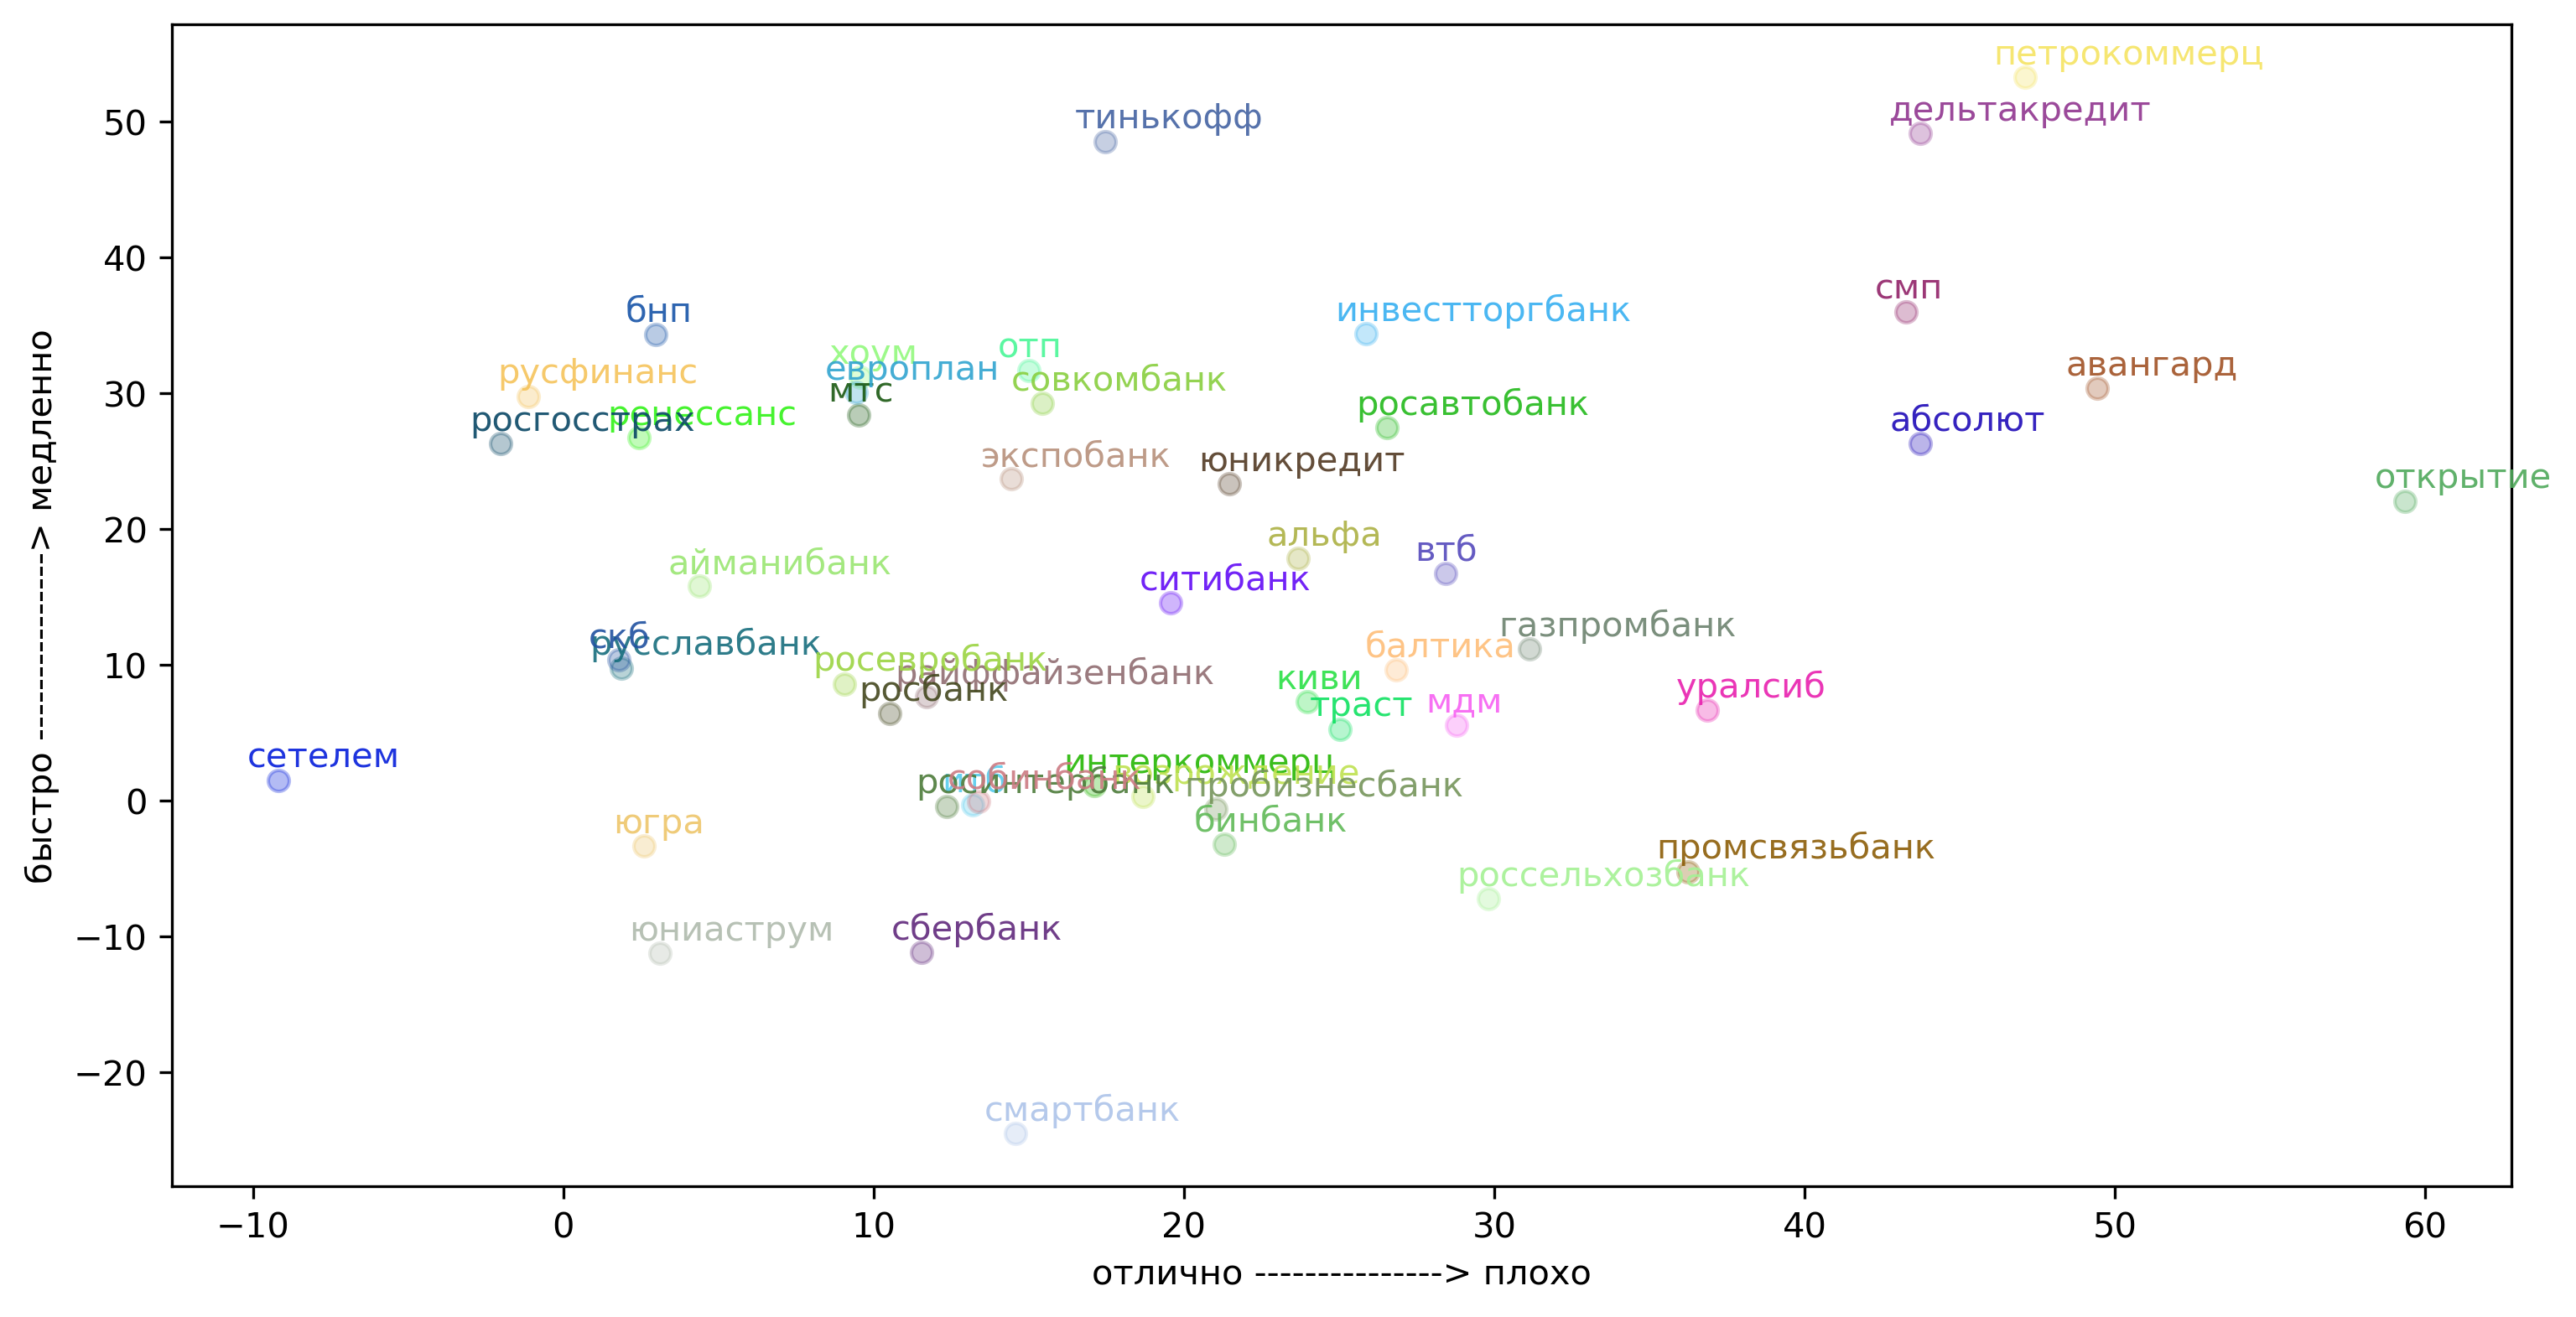

In [38]:
banks = ['сбербанк', 'втб', 'тинькофф', 'отп', 'промсвязьбанк', 'экспобанк',
         'райффайзенбанк', 'совкомбанк', 'газпромбанк', 'юникредит', 'альфа',
         'авангард', 'открытие', 'бинбанк', 'росбанк', 'киви', 'мтс', 'мдм',
         'уралсиб', 'сетелем', 'ситибанк', 'ренессанс', 'траст', 'хоум',
         'юниаструм', 'айманибанк', 'русславбанк', 'русфинанс', 'абсолют',
         'балтика', 'инвестторгбанк', 'европлан', 'росевробанк', 'итб', 'скб',
         'интеркоммерц', 'возрождение', 'смартбанк', 'росавтобанк', 
         'петрокоммерц', 'россельхозбанк', 'пробизнесбанк', 'дельтакредит',
         'росгосстрах', 'бнп', 'росинтербанк', 'смп', 'югра', 'собинбанк']

word2vec_plot(model, banks, 'отлично', 'плохо', 'быстро', 'медленно')

In [41]:
keys_tsne = model.wv.index_to_key[:100]
embedding_clusters = []
word_clusters = []

for word in keys_tsne:
    embeddings = []
    words = []
    for similar_word, _ in model.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(model.wv.get_vector(similar_word))
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

tsne_model_en_2d = TSNE(perplexity=50, n_components=2, init='pca', n_iter=3500, random_state=42)
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


/var/folders/wt/ln3qm_qx66x2xn97lw7_xg_c0000gn/T/ipykernel_2659/546778128.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, alpha=0.7, label=label)


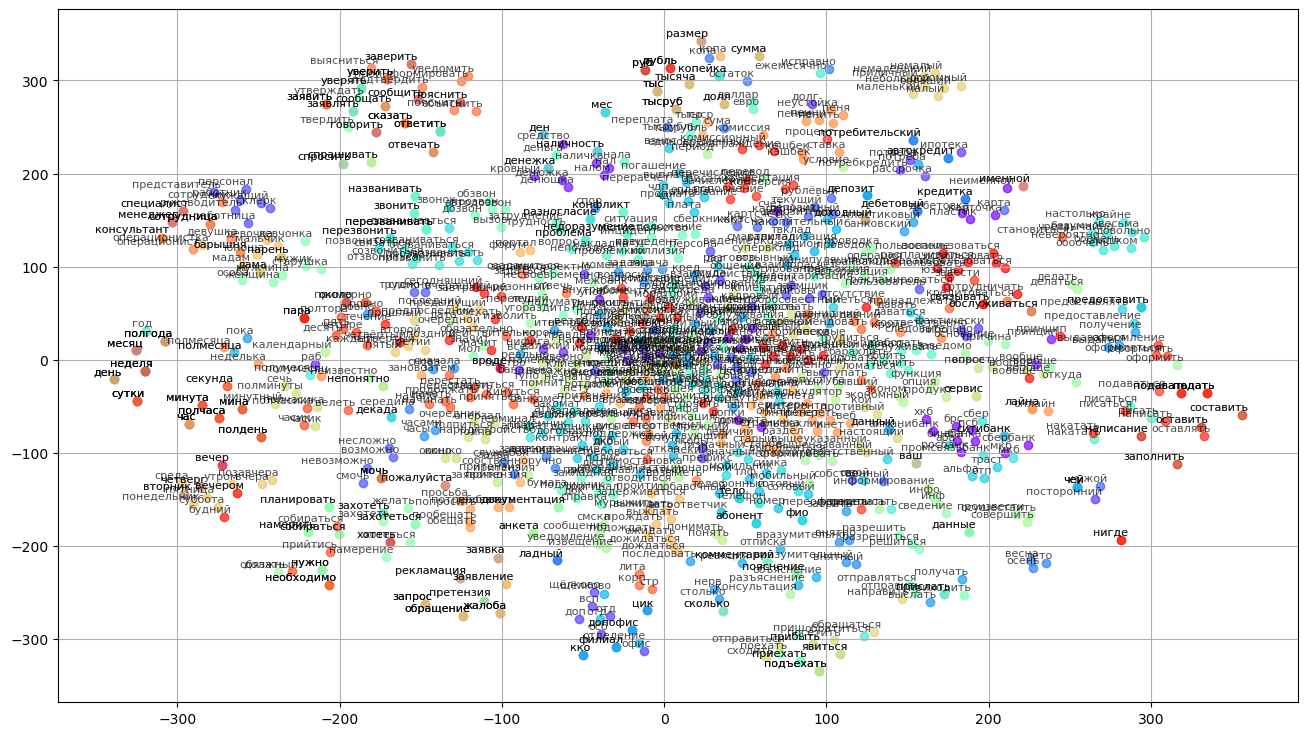

In [46]:
plt.figure(figsize=(16, 9))
colors = cm.rainbow(np.linspace(0, 1, len(keys_tsne)))

for label, embeddings, words, color in zip(keys_tsne, embeddings_en_2d, word_clusters, colors):
    x = embeddings[:,0]
    y = embeddings[:,1]

    plt.scatter(x, y, c=color, alpha=0.7, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.7, xy=(x[i], y[i]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom', size=8)

# plt.legend(loc=4)
plt.grid(True)
plt.show()

Визуально можно выделить конкретные кластеры, например:

- временные промежутки - посередине слева (неделя, день, полгода, сутки и тд)
- разговоры - сверху слева (отвечать, заявлять, ответить и тд)
- передвижение - посередине снизу (приезать, явиться, отправиться)

## Часть 2. Распространение метки [50 баллов]

Определите 5-8 позитивных слов (например, “быстрый”, “удобный”) и 5-8  негативных слов (например,“очередь”, “медленно”). Эти слова будут основной будущего оценочного словаря. Пусть позитивному классу соответствует метка 1, негативному – -1. Пометьте выбранные слова в лексическом графе соответствующими метками. Запустите любой известный вам метод распространения метки (Label Propogation) в лексическом графе. На выходе метода распространения ошибки должны быть новые слова, помеченные метками 1 и -1 – это и есть искомые оценочные слова.

Алгоритмы распространения метки устроены примерно так: пусть мы находимся в выршине, помеченном +1. С какой-то вероятностью мы переносим эту метку на соседние узлы. С меньшей вероятностью переносим ее на вершины на расстоянии два. В конце распространения метки, часть вершин оказывается помечена меткой +1, часть – -1, большая часть остается без метки.

Рекомендуемые алгоритмы распространения метки:
1. ```graphlab.label_propagation``` (```graphlab``` доступен бесплатно по образовательной лицензии)
2. ```sklearn.semi_supervised.LabelPropagation```
3. ```sklearn.semi_supervised.LabelSpreading```

In [8]:
pip install python-igraph

Note: you may need to restart the kernel to use updated packages.


In [23]:
import igraph as ig
from sklearn.semi_supervised import LabelSpreading

In [11]:
unique_words = list(model.wv.key_to_index.keys())

g = ig.Graph(directed=True)
for word in unique_words:
    g.add_vertex(word)
    
for word in unique_words:
    node = g.vs.select(name = word).indices[0]
    similar_words = model.wv.most_similar(word, topn=5)
    for sim in similar_words:
        word1 = sim[0]
        val  = sim[1]
        new_node = g.vs.select(name = word1).indices[0]
        g.add_edge(node, new_node, weight = val)

In [85]:
X = np.zeros((len(unique_words), len(unique_words)))
for edge, weight in zip(g.get_edgelist(), g.es['weight']):
    X[edge[0], edge[1]] = weight
    X[edge[1], edge[0]] = weight

for i in range(len(X)):
    X[i, i] = 1
X

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [71]:
positive = ['быстрый', 'удобный', 'отличный', 'помощь', 'спасибо']
negative = ['очередь', 'медленно', 'плохой', 'неудобно', 'ужасно']

labels = np.full(len(unique_words), -1, dtype=int)
for word in positive:
    labels[g.vs.find(word).index] = 1
for word in negative:
    labels[g.vs.find(word).index] = 0

In [72]:
model = LabelSpreading(kernel='knn', alpha=0.7, max_iter=500)
model.fit(X, labels)

LabelSpreading(alpha=0.7, kernel='knn', max_iter=500)

In [83]:
pred = model.transduction_
pred

array([1, 1, 1, ..., 1, 1, 0])

In [81]:
new_labels = {}
for key, val in zip(g.vs['name'], pred):
    new_labels[key] = val if val == 1 else -1

new_labels

{'банк': 1,
 'карта': 1,
 'это': 1,
 'деньга': 1,
 'день': -1,
 'всё': 1,
 'кредит': 1,
 'который': 1,
 'отделение': 1,
 'клиент': -1,
 'сотрудник': 1,
 'мочь': -1,
 'счёт': 1,
 'свой': 1,
 'сказать': 1,
 'сумма': 1,
 'заявление': 1,
 'год': -1,
 'вопрос': 1,
 'время': -1,
 'ещё': 1,
 'получить': 1,
 'кредитный': -1,
 'весь': 1,
 'ответ': 1,
 'вклад': 1,
 'офис': 1,
 'телефон': 1,
 'платёж': 1,
 'договор': 1,
 'ваш': 1,
 'дать': 1,
 'номер': 1,
 'звонить': 1,
 'банкомат': 1,
 'сбербанк': 1,
 'очень': 1,
 'позвонить': 1,
 'месяц': -1,
 'написать': 1,
 'проблема': 1,
 'работать': 1,
 'средство': 1,
 'рубль': 1,
 'работа': 1,
 'документ': 1,
 'ситуация': 1,
 'звонок': 1,
 'прийти': -1,
 'решить': 1,
 'говорить': 1,
 'человек': 1,
 'хотеть': 1,
 'операция': -1,
 'почему': 1,
 'должный': -1,
 'информация': 1,
 'сделать': 1,
 'смс': 1,
 'срок': 1,
 'услуга': 1,
 'заявка': 1,
 'знать': 1,
 'просто': -1,
 'обслуживание': 1,
 'очередь': -1,
 'минута': -1,
 'обратиться': 1,
 'данный': 1,
 'больш